In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint
import pandas as pd
from scipy.optimize import minimize

In [2]:
#ODEs Listed in Paper
# k, ks, kd, and Y are kinetic parameters that will need to be estimated
# Iph = 1 for simplicity
# fi = stoich coeff

# dSdt = -k*(S/(ks+S))*(X*Iph)
# dXdt = -Y*(dSdt)-(kd*X)
# dSidt = -(1-Y)*fi*dSdt

# nu = k*S/(ks+S)

# SSE = SUM{(nui - kSi/(ks+Si))**2}

#THERE ARE SEVERAL CHEMICAL SPECIES EVALUATED IN THE PAPER. I WILL ONLY BE FOCUSING ON H2
#SUBSTRATE IS GLUCOSE

In [3]:
timesteps = np.linspace(0,50,100) #hours - via scaling from the paper
Iph = 1
Vreactor = .12 #L
MWg = 180 #g/mol
MWh2 = 2 #g/mol

In [4]:
S0 = 5.0 #g/L
X0 = 0.1 #g/L
SH20 = 0.0
initvals = [S0,X0,SH20] #g/L via paper recommendation
# k = 1
# ks = 1
# kd = 1
# Y = 1
fH2 = 3.25

#VALUES IN CONCLUSION OF PAPER - FOR VERIFICATION
k = 0.839 # 1/h
ks = 1.42 # g/L
Y = 0.1204 #unitless
kd = 0.0043 # 1/h

params1 = k,ks,Y,kd

In [5]:
def odes(z,t):
    S = z[0]
    X = z[1]
    SH2 = z[2]
    
    k,ks,Y,kd = params1
    nu = k*S/(ks+S)
    
    dSdt = -k*(S/(ks+S))*(X*Iph)
    dXdt = -Y*(dSdt)-(kd*X)
    dSH2dt = -(1-Y)*fH2*dSdt
    
    return([dSdt,dXdt,dSH2dt])

In [6]:
z=odeint(odes,initvals,timesteps)

In [7]:
# print(z)

In [8]:
# GLUCOSE CONSUMED
gconsum = 26.3 #mM from paper
molg = z[:,0]*Vreactor/MWg #mol
molh2 = z[:,2]*Vreactor/MWh2 #mol
molg0 = S0*Vreactor/MWg
gconsum = gconsum/1000*Vreactor

In [9]:
#Putting it in units for data comparison
h2dat = np.zeros(len(molh2))
for i in range(len(h2dat)):
    h2dat[i] = molh2[i]/gconsum/90

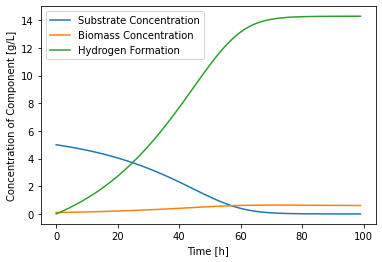

In [10]:
plt.plot(z);
plt.xlabel('Time [h]');
plt.ylabel('Concentration of Component [g/L]');
plt.legend(['Substrate Concentration','Biomass Concentration','Hydrogen Formation']);
plt.title;

In [11]:
#Importing data captured from paper
xdatlist=pd.read_csv(r'xdatlist.csv')
ydatlist=pd.read_csv(r'ydatlist.csv')
xdat = xdatlist['x'].tolist() # time (hr)
ydat = ydatlist['y'].tolist() # mol H2/mol glucose consumed
# print(xdat)
# print(ydat)

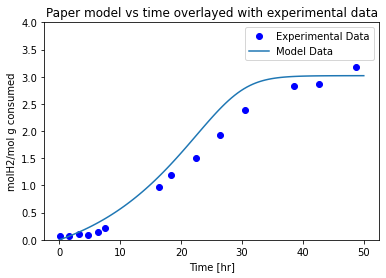

In [12]:
plt.plot(xdat,ydat,'bo');
plt.plot(timesteps,h2dat);
plt.ylim([0.,4.]);
plt.ylabel('molH2/mol g consumed');
plt.xlabel('Time [hr]');
plt.title('Paper model vs time overlayed with experimental data');
plt.legend(['Experimental Data','Model Data']);

## Attempting to Minimize Model Errors from Parameters

In [13]:
def h2integrator(z,t,params1):
    z = odeint(odes,initvals,timesteps)
    myh2dat = z[:,2]*Vreactor/MWh2/gconsum/90 #mol
    return myh2dat

In [14]:
x0 = [1,1,1,1];
n = h2integrator(initvals,timesteps,params1)
# print(n)

In [15]:
def objective(params):
    err = ydat-vals
    return np.sum(err**2)

In [16]:
vals = np.zeros(len(ydat))
for i in range(len(n)):
    for j in range(len(vals)):
        if (n[i]-ydat[j])<=0.1:
            vals[j] = n[i]
            
# print(vals)

In [17]:
x0 = [.9,1.4,.1,.002];
# ydat = np.array(ydat)
print(ydat)
sol = minimize(objective, x0);
print(sol);

[0.06121972, 0.070527607, 0.101750353, 0.097061619, 0.139494494, 0.220736291, 0.967402841, 1.194124862, 1.500071803, 1.92235436, 2.379467656, 2.826746527, 2.86412456, 3.17423753]
      fun: 0.11852895077650444
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.9  , 1.4  , 0.1  , 0.002])


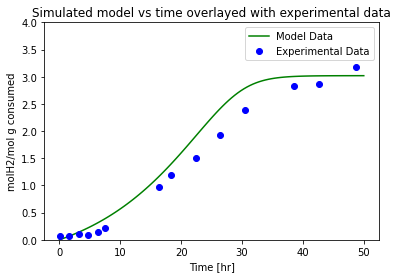

In [18]:
tfit = np.linspace(min(timesteps), max(timesteps),100);
plt.plot(tfit, n,'g', label='fit');
plt.plot(xdat,ydat,'bo');
plt.ylim([0.,4.]);
plt.ylabel('molH2/mol g consumed');
plt.xlabel('Time [hr]');
plt.title('Simulated model vs time overlayed with experimental data');
plt.legend(['Model Data','Experimental Data']);

## Bifurcation Analysis - Evaluating "k"

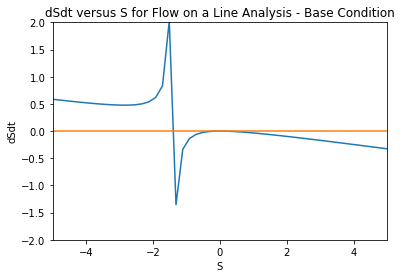

In [19]:
#Flow on a line analysis
myS = np.linspace(-10,10,100)
myX = np.linspace(-1,1,100)

dSdt = -k*(myS/(ks+myS))*(myX*Iph)
dXdt = -Y*(dSdt)-(kd*myX)
dSH2dt = -(1-Y)*fH2*dSdt
axis = np.zeros(len(myS))
plt.plot(myS,dSdt);
plt.plot(myS,axis);
plt.title('dSdt versus S for Flow on a Line Analysis - Base Condition');
plt.xlabel('S');
plt.ylabel('dSdt');
plt.ylim([-2,2]);
plt.xlim([-5,5]);

#### It can be seen that there is a steady state near (0,0)

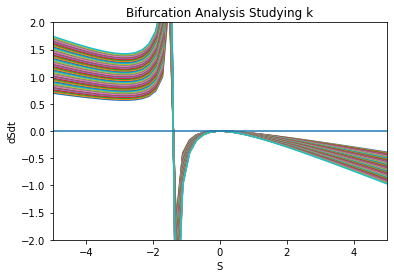

In [20]:
#Bifurcation analsysis by testing a range of k values
newk = np.linspace(1,2.5,50)
newdSdt = np.zeros((len(newk),len(myS)))
storage = np.zeros(len(newk))
for i in range(len(newk)):
    for j in range(len(myS)):
        newdSdt[i][j] = -newk[i]*(myS[j]/(ks+myS[j]))*(myX[j]*Iph)
        if newdSdt[i][j] > -0.01 and newdSdt[i][j] < 0.01:
            storage[i] = myS[j]
# print(newk)
# print(storage)
for i in range(len(newk)):
    plt.plot(myS,newdSdt[i]);
    
    
plt.title('Bifurcation Analysis Studying k');
plt.ylabel('dSdt');
plt.xlabel('S');
plt.plot(myS,axis);
plt.ylim([-2,2]);
plt.xlim([-5,5]);

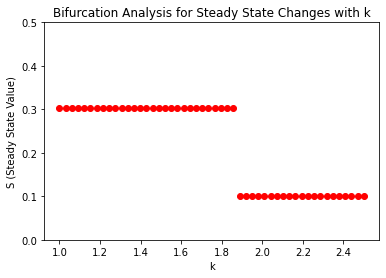

In [21]:
plt.plot(newk,storage,'ro');
plt.title('Bifurcation Analysis for Steady State Changes with k');
plt.ylabel('S (Steady State Value)');
plt.xlabel('k');
plt.ylim([0.,.5]);

#### The steady-state location changes when k passes through roughly 1.8-1.9

## Sensitivity Analysis - Perturbing by 1% and 5%

### 1% Case

In [22]:
def sens(z,t,k,ks,Y,kd):
    S = z[0]
    X = z[1]
    SH2 = z[2]
    
    nu = k*S/(ks+S)
    
    dSdt = -k*(S/(ks+S))*(X*Iph)
    dXdt = -Y*(dSdt)-(kd*X)
    dSH2dt = -(1-Y)*fH2*dSdt
    
    return([dSdt,dXdt,dSH2dt])

In [23]:
y = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204,0.0043))
y1 = odeint(sens, initvals, timesteps, args = (0.839*1.01,1.42,0.1204,0.0043))
y2 = odeint(sens, initvals, timesteps, args = (0.839,1.42*1.01,0.1204,0.0043))
y3 = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204*1.01,0.0043))
y4 = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204,0.0043*1.01))

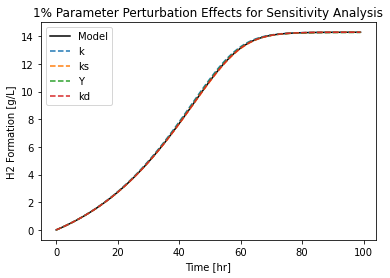

In [24]:
plt.plot(y[:,2],'k');
plt.plot(y1[:,2],'--');
plt.plot(y2[:,2],'--');
plt.plot(y3[:,2],'--');
plt.plot(y4[:,2],'--');
plt.legend(['Model','k','ks','Y','kd']);
plt.xlabel('Time [hr]');
plt.ylabel('H2 Formation [g/L]');
plt.title('1% Parameter Perturbation Effects for Sensitivity Analysis');

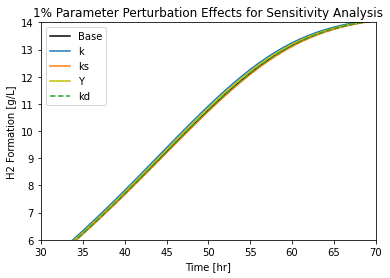

In [25]:
#Zoomed in version
plt.plot(y[:,2],'k');
plt.plot(y1[:,2]);
plt.plot(y2[:,2]);
plt.plot(y3[:,2],'y');
plt.plot(y4[:,2],'--');
plt.legend(['Base','k','ks','Y','kd']);
plt.ylim([6,14]);
plt.xlim([30,70]);
plt.xlabel('Time [hr]');
plt.ylabel('H2 Formation [g/L]');
plt.title('1% Parameter Perturbation Effects for Sensitivity Analysis');

### 5% Case

In [26]:
# k = 0.839 # 1/h
# ks = 1.42 # g/L
# Y = 0.1204 #unitless
# kd = 0.0043
# y = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204,0.0043))
# y1 = odeint(sens, initvals, timesteps, args = (0.839*1.05,1.42,0.1204,0.0043))
# y2 = odeint(sens, initvals, timesteps, args = (0.839,1.42*1.05,0.1204,0.0043))
# y3 = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204*1.05,0.0043))
# y4 = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204,0.0043*1.05))
y = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204,0.0043))
y1 = odeint(sens, initvals, timesteps, args = (0.839*0.95,1.42,0.1204,0.0043))
y2 = odeint(sens, initvals, timesteps, args = (0.839,1.42*0.95,0.1204,0.0043))
y3 = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204*0.95,0.0043))
y4 = odeint(sens, initvals, timesteps, args = (0.839,1.42,0.1204,0.0043*0.95))

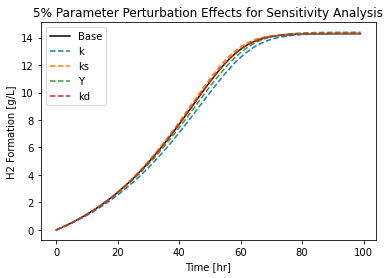

In [27]:
plt.plot(y[:,2],'k');
plt.plot(y1[:,2],'--');
plt.plot(y2[:,2],'--');
plt.plot(y3[:,2],'--');
plt.plot(y4[:,2],'--');
plt.legend(['Base','k','ks','Y','kd']);
plt.title('5% Parameter Perturbation Effects for Sensitivity Analysis');
plt.xlabel('Time [hr]');
plt.ylabel('H2 Formation [g/L]');

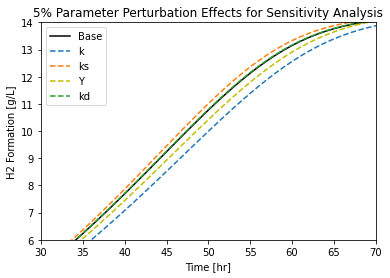

In [28]:
#Zoomed in version
plt.plot(y[:,2],'k');
plt.plot(y1[:,2],'--');
plt.plot(y2[:,2],'--');
plt.plot(y3[:,2],'y--');
plt.plot(y4[:,2],'--');
plt.legend(['Base','k','ks','Y','kd']);
plt.ylim([6,14]);
plt.xlim([30,70]);
plt.xlabel('Time [hr]');
plt.ylabel('H2 Formation [g/L]');
plt.title('5% Parameter Perturbation Effects for Sensitivity Analysis');

#### The most sensitive parameter was found to be k in this case as it holds the largest offset compared to the base case from the paper.

### These next sections convert the above data to the units that are able to be compared to the raw data

In [29]:
# GLUCOSE CONSUMED - y - base case
gconsum = 26.3 #mM from paper
molg = y[:,0]*Vreactor/MWg #mol
molh2 = y[:,2]*Vreactor/MWh2 #mol
molg0 = S0*Vreactor/MWg
gconsum = gconsum/1000*Vreactor

In [30]:
h2dat = np.zeros(len(molh2))
for i in range(len(h2dat)):
    h2dat[i] = molh2[i]/gconsum/90

In [31]:
# GLUCOSE CONSUMED - y1
gconsum = 26.3 #mM from paper
molg1 = y1[:,0]*Vreactor/MWg #mol
molh21 = y1[:,2]*Vreactor/MWh2 #mol
molg0 = S0*Vreactor/MWg
gconsum = gconsum/1000*Vreactor

In [32]:
h2dat1 = np.zeros(len(molh21))
for i in range(len(h2dat1)):
    h2dat1[i] = molh21[i]/gconsum/90

In [33]:
# GLUCOSE CONSUMED - y2
gconsum = 26.3 #mM from paper
molg2 = y2[:,0]*Vreactor/MWg #mol
molh22 = y2[:,2]*Vreactor/MWh2 #mol
molg0 = S0*Vreactor/MWg
gconsum = gconsum/1000*Vreactor

In [34]:
h2dat2 = np.zeros(len(molh22))
for i in range(len(h2dat2)):
    h2dat2[i] = molh22[i]/gconsum/90

In [35]:
# GLUCOSE CONSUMED - y3
gconsum = 26.3 #mM from paper
molg3 = y3[:,0]*Vreactor/MWg #mol
molh23 = y3[:,2]*Vreactor/MWh2 #mol
molg0 = S0*Vreactor/MWg
gconsum = gconsum/1000*Vreactor

In [36]:
h2dat3 = np.zeros(len(molh23))
for i in range(len(h2dat3)):
    h2dat3[i] = molh23[i]/gconsum/90

In [37]:
# GLUCOSE CONSUMED - y4
gconsum = 26.3 #mM from paper
molg4 = y4[:,0]*Vreactor/MWg #mol
molh24 = y4[:,2]*Vreactor/MWh2 #mol
molg0 = S0*Vreactor/MWg
gconsum = gconsum/1000*Vreactor

In [38]:
h2dat4 = np.zeros(len(molh24))
for i in range(len(h2dat4)):
    h2dat4[i] = molh24[i]/gconsum/90

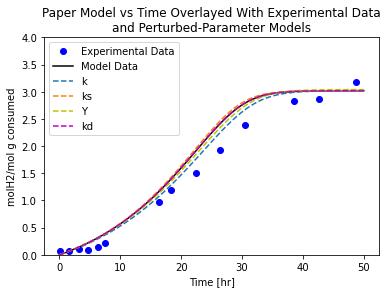

In [39]:
plt.plot(xdat,ydat,'bo');
plt.plot(timesteps,h2dat,'k');
plt.plot(timesteps,h2dat1,'--');
plt.plot(timesteps,h2dat2,'--');
plt.plot(timesteps,h2dat3,'y--');
plt.plot(timesteps,h2dat4,'m--');
plt.ylim([0.,4.]);
plt.ylabel('molH2/mol g consumed');
plt.xlabel('Time [hr]');
plt.title('Paper Model vs Time Overlayed With Experimental Data\nand Perturbed-Parameter Models');
plt.legend(['Experimental Data','Model Data','k','ks','Y','kd']);

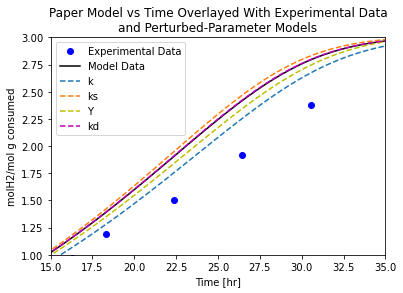

In [40]:
#Zoomed in version
plt.plot(xdat,ydat,'bo');
plt.plot(timesteps,h2dat,'k');
plt.plot(timesteps,h2dat1,'--');
plt.plot(timesteps,h2dat2,'--');
plt.plot(timesteps,h2dat3,'y--');
plt.plot(timesteps,h2dat4,'m--');
plt.ylim([1.0,3.]);
plt.xlim([15,35])
plt.ylabel('molH2/mol g consumed');
plt.xlabel('Time [hr]');
plt.title('Paper Model vs Time Overlayed With Experimental Data\nand Perturbed-Parameter Models');
plt.legend(['Experimental Data','Model Data','k','ks','Y','kd']);

## Revisiting Parameter Fitting, Only Trying to Fit k

In [41]:
def revisit(newz,t,newk):
    S = newz[0]
    X = newz[1]
    SH2 = newz[2]
    k = newk[0]
#     print(k)
    ks = 1.42 # g/L
    Y = 0.1204 #unitless
    kd = 0.0043
    nu = k*S/(ks+S)
    
    dSdt = -k*(S/(ks+S))*(X*Iph)
    dXdt = -Y*(dSdt)-(kd*X)
    dSH2dt = -(1-Y)*fH2*dSdt
    
    return ([dSdt,dXdt,dSH2dt])

In [42]:
def objective(newk):
    
    S0 = 5.0 #g/L
    X0 = 0.1 #g/L
    SH20 = 0.0
    initvals = np.array((S0,X0,SH20));
    y0=initvals.reshape(3,)
#     print(y0)
    timesteps = np.linspace(0,50,100)
    newvals = np.zeros(len(ydat))
    
    newz = odeint(revisit,y0,timesteps,args = (newk,))
    
    myh2dat = newz[:,2]*Vreactor/MWh2/gconsum/90 #mol
    for i in range(len(myh2dat)):
        for j in range(len(newvals)):
            if (myh2dat[i]-ydat[j])<=0.1:
                newvals[j] = myh2dat[i]
    
    
    err = ydat-newvals
    return np.sum(err**2)

In [43]:
guessk = .7
newsol = minimize(objective, (guessk,));
print(newsol);

      fun: 0.10981087853203648
 hess_inv: array([[0.00771079]])
      jac: array([2.90716377])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 96
      nit: 1
     njev: 45
   status: 2
  success: False
        x: array([0.69730998])


### Our minimizied parameter value of k was found to be 0.69730998

In [44]:
#Re-plotting with this new parameter
ynew = odeint(sens, initvals, timesteps, args = (0.69730998,1.42,0.1204,0.0043))

In [45]:
# GLUCOSE CONSUMED - optimized model
gconsum = 26.3 #mM from paper
molg = ynew[:,0]*Vreactor/MWg #mol
molh2new = ynew[:,2]*Vreactor/MWh2 #mol
molg0 = S0*Vreactor/MWg
gconsum = gconsum/1000*Vreactor

In [46]:
h2datnew = np.zeros(len(molh2new))
for i in range(len(h2datnew)):
    h2datnew[i] = molh2new[i]/gconsum/90

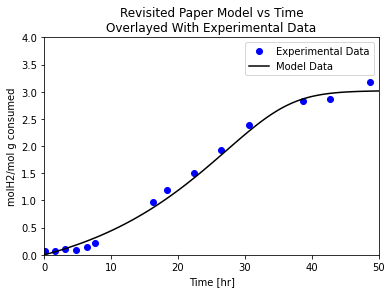

In [47]:
#Zoomed in version
plt.plot(xdat,ydat,'bo');
plt.plot(timesteps,h2datnew,'k');
plt.ylim([0.,4]);
plt.xlim([0.,50])
plt.ylabel('molH2/mol g consumed');
plt.xlabel('Time [hr]');
plt.title('Revisited Paper Model vs Time\nOverlayed With Experimental Data');
plt.legend(['Experimental Data','Model Data','k','ks','Y','kd']);

#### After revisiting the parameter optimization, it can be seen that the proposed model holds a much better fit than the original attempt with all parameters